In [1]:
import numpy as np
import pandas as pd

In [2]:
# Mounting the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls -l

total 8
drwx------ 6 root root 4096 Mar 20 06:45 drive
drwxr-xr-x 1 root root 4096 Mar  9 14:48 sample_data


#### Model Prediction

In [4]:
import tensorflow as tf

Load Saved model

In [5]:
!ls -l

total 8
drwx------ 6 root root 4096 Mar 20 06:45 drive
drwxr-xr-x 1 root root 4096 Mar  9 14:48 sample_data


In [6]:
saved_model_path = '/content/drive/MyDrive/GL_AIML_Course/Projects/AIML_Learning/Capstone_Project/Notebooks/SavedModels_SSD/saved_model'
model = tf.saved_model.load(saved_model_path)

In [7]:
model

<tensorflow.python.saved_model.load.Loader._recreate_base_user_object.<locals>._UserObject at 0x7f120f1eecd0>

In [8]:
label_class_dict = {4: 'GMC Yukon Hybrid SUV 2012', 6: 'Spyker C8 Coupe 2009', 2: 'Bentley Arnage Sedan 2009', 5: 'McLaren MP4-12C Coupe 2012', 1: 'Aston Martin Virage Convertible 2012', 3: 'Chrysler Crossfire Convertible 2008'}

Function to get model prediction

In [16]:
#Function to get predictions from a Detection model
def detector_prediction(image_file, confidence_threshold=0.5):

    """
    image_file: File path of the image for which prediction needs to be done
    confidence_threshold: Minimum confidence/probability for prediction to be considered
    """
    #Load image
    img = tf.keras.preprocessing.image.load_img(image_file)
    
    # plt.figure(figsize=(10,6))
    # plt.imshow(img)
    # plt.show()

    #Convert to numpy array
    img_array = tf.keras.preprocessing.image.img_to_array(img).astype('uint8')
    #Make it a batch of one example
    img_array = tf.expand_dims(img_array, axis=0)

    #Prediction
    output = model(img_array) #get list of tensors discussed above as output
    # print(output)
    detection_scores = output['detection_scores'].numpy()[0] #get detection scores
    detection_classes = output['detection_classes'].numpy()[0]
    detection_boxes = output['detection_boxes'].numpy()[0]

    # print(detection_scores)
    # print(detection_classes)
    # print(detection_boxes)

    #Select predictions for which probability is higher than confidence_threshold
    selected_predictions = detection_scores >= confidence_threshold

    selected_prediction_scores = detection_scores[selected_predictions]
    selected_prediction_classes = detection_classes[selected_predictions]
    selected_prediction_boxes = detection_boxes[selected_predictions]

    #De-normalize box co-ordinates (multiply x-coordinates by image width and y-coords by image height)
    img_w, img_h = img.size

    for i in range(selected_prediction_boxes.shape[0]):
        
        selected_prediction_boxes[i,0] *= img_h #ymin * img_w
        selected_prediction_boxes[i,1] *= img_w #xmin * img_h
        selected_prediction_boxes[i,2] *= img_h #ymax * img_w
        selected_prediction_boxes[i,3] *= img_w #xmax * img_h

    #Make all co-ordinates as integer
    selected_prediction_boxes= selected_prediction_boxes.astype(int)

    #Convert class indexes to actual class labels
    predicted_classes = []
    for i in range(selected_prediction_classes.shape[0]):
        # print(carNameDF.loc[carNameDF["Imageclass"] == int(selected_prediction_classes[i]),"ImageClassName"].item())
        # predicted_classes.append(carNameDF.loc[carNameDF["Imageclass"] == int(selected_prediction_classes[i]),"ImageClassName"].item())
        print(selected_prediction_classes[i])
        predicted_classes.append(label_class_dict[int(selected_prediction_classes[i])])

    #Number of predictions
    selected_num_predictions = selected_prediction_boxes.shape[0]

    return {'Total Predictions': selected_num_predictions,
            'Scores': selected_prediction_scores, 
            'Classes': predicted_classes, 
            'Box coordinates': selected_prediction_boxes}

Copy an image to predict on

In [17]:
!cp '/content/drive/MyDrive/GL_AIML_Course/Projects/AIML_Learning/Capstone_Project/Notebooks/Car_Images/Test_Images/Aston Martin V8 Vantage Convertible 2012/00571.jpg' .

In [18]:
!ls -l

total 516
-rw------- 1 root root 516953 Mar 20 06:46 00571.jpg
drwx------ 6 root root   4096 Mar 20 06:45 drive
drwxr-xr-x 1 root root   4096 Mar  9 14:48 sample_data


In [19]:
#Model output
detector_prediction('00571.jpg', confidence_threshold=0.5)

1.0
6.0


{'Box coordinates': array([[193,  52, 562, 937],
        [171,  38, 546, 976]]),
 'Classes': ['Aston Martin Virage Convertible 2012', 'Spyker C8 Coupe 2009'],
 'Scores': array([0.7029358, 0.5733771], dtype=float32),
 'Total Predictions': 2}

Visualize model output

In [20]:
import cv2
from matplotlib import pyplot as plt

In [21]:
def visualize_output(image_file, confidence_threshold=0.5):

    #Call model prediction function above
    output = detector_prediction(image_file, confidence_threshold=confidence_threshold)

    #Read image
    img = cv2.imread(image_file)

    #Draw rectangle for predicted boxes, also add predicted classes
    for i in range(output['Box coordinates'].shape[0]):
      
      box = output['Box coordinates'][i]
      #Draw rectangle - (ymin, xmin, ymax, xmax)
      img = cv2.rectangle(img, (box[1], box[0]), (box[3], box[2]), (0,255,0), 5)
      
      #Add Label - Class name and confidence level
      label = output['Classes'][i] + ': ' + str(round(output['Scores'][i],2))
      img = cv2.putText(img, label, (box[1], box[0]-10), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    #Conver BGR image to RGB to use with Matplotlib
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    #Display image
    plt.figure(figsize=(10,6))
    plt.imshow(img)
    plt.show()

1.0


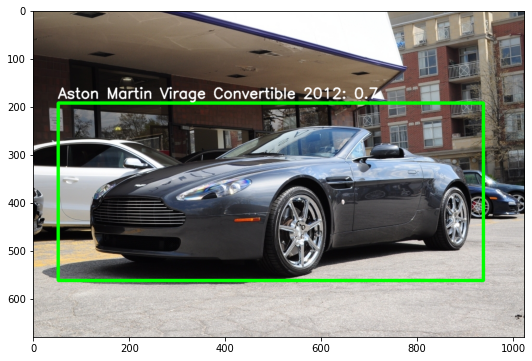

In [22]:
#Visualize on image
visualize_output('00571.jpg', confidence_threshold=0.65)

In [23]:
label_class_dict

{1: 'Aston Martin Virage Convertible 2012',
 2: 'Bentley Arnage Sedan 2009',
 3: 'Chrysler Crossfire Convertible 2008',
 4: 'GMC Yukon Hybrid SUV 2012',
 5: 'McLaren MP4-12C Coupe 2012',
 6: 'Spyker C8 Coupe 2009'}

1.0


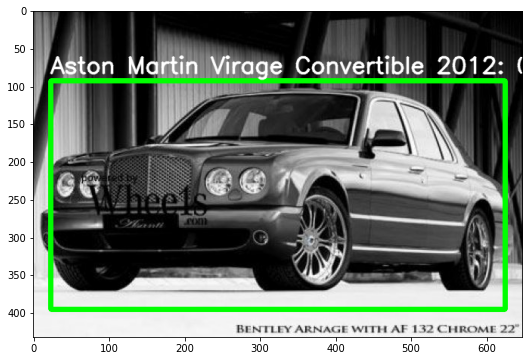

In [24]:
!cp '/content/drive/MyDrive/GL_AIML_Course/Projects/AIML_Learning/Capstone_Project/Notebooks/Car_Images/Test_Images/Bentley Arnage Sedan 2009/02407.jpg' .
#Visualize on image
visualize_output('02407.jpg', confidence_threshold=0.64)

4.0


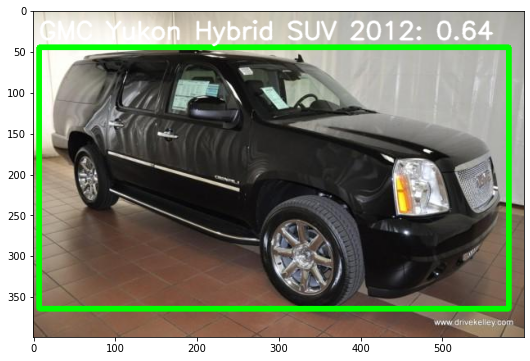

In [29]:
!cp '/content/drive/MyDrive/GL_AIML_Course/Projects/AIML_Learning/Capstone_Project/Notebooks/Car_Images/Test_Images/GMC Yukon Hybrid SUV 2012/04127.jpg' .
#Visualize on image
visualize_output('04127.jpg', confidence_threshold=0.64)

6.0


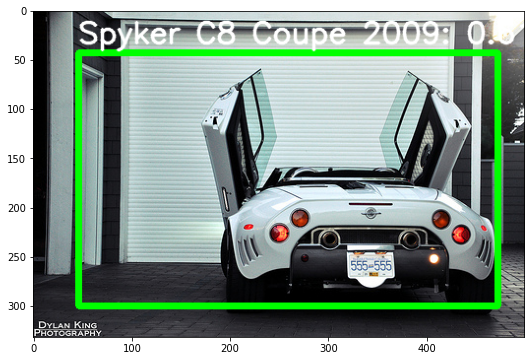

In [32]:
!cp '/content/drive/MyDrive/GL_AIML_Course/Projects/AIML_Learning/Capstone_Project/Notebooks/Car_Images/Test_Images/Spyker C8 Coupe 2009/00411.jpg' .

#Visualize on image
visualize_output('00411.jpg', confidence_threshold=0.6)

1.0


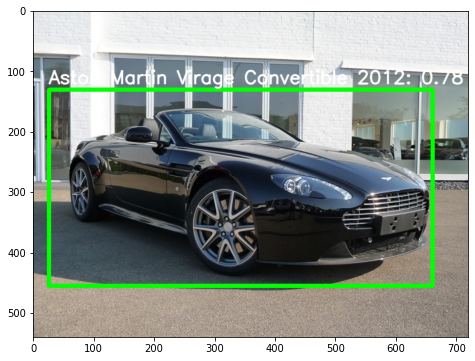

In [33]:


!cp '/content/drive/MyDrive/GL_AIML_Course/Projects/AIML_Learning/Capstone_Project/Notebooks/Car_Images/Test_Images/Aston Martin V8 Vantage Convertible 2012/00239.jpg' .

#Visualize on image
visualize_output('00239.jpg', confidence_threshold=0.64)